In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34, resnet18  # Using a basic, small ResNet variant
from torch import nn

# Transformation for CIFAR-10 images
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Standard normalization for CIFAR-10
# ])

# Transforms from: https://colab.research.google.com/github/Rakshit-Shetty/Resnet-Implementation/blob/master/ResNet_Implementation_on_CIFAR10.ipynb#scrollTo=l5WmV1je_1kr
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data/train', train=True, download=True,
                                        transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data/test', train=False, download=True,
                                        transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(trainset)
print(testset)
print(f'Classes: {classes}')

# Modify ResNet for CIFAR-10 (assume using resnet18)
model = resnet34()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusting first conv layer to accept 32x32 input
model.maxpool = nn.Identity()  # Remove maxpool to keep dimensionality
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting final fully connected layer for 10 classes

# Assuming use of a GPU if available
device = torch.device("mps")
model.to(device)

def evaluate_model(testing_model, dataloader, suppress_output=False):
    testing_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = testing_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if not suppress_output:
        print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/train
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
import torch.optim as optim
from torch import nn

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Define number of epochs
num_epochs = 20

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss: {running_loss / 200:.4f}')
            print(f'\tAcc (Test data): {evaluate_model(model, testloader, suppress_output=True)}')
            running_loss = 0.0

print('Finished Training')
# torch.save(model.state_dict(), "state")

# Evaluate the model
evaluate_model(model, testloader)


In [ ]:
torch.save(model.state_dict(), "state")

In [2]:
# Set up model structure as before

model = resnet34()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusting first conv layer to accept 32x32 input
model.maxpool = nn.Identity()  # Remove maxpool to keep dimensionality
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting final fully connected layer for 10 classes
model.to(device)

# Load stored weights

model.load_state_dict(torch.load("state"))
evaluate_model(model, testloader)


Accuracy of the model on the test images: 80.71%


80.71

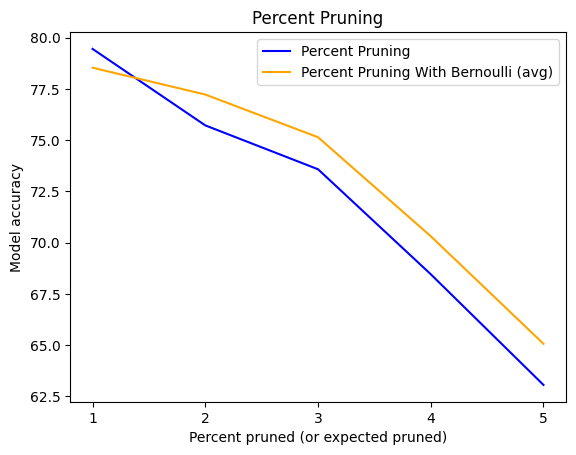

In [3]:
%load_ext autoreload
%autoreload now
import copy
import pruning_funcs
import numpy as np
import matplotlib.pyplot as plt

percent_prune = []
percent_prune_with_bernoulli = []

percents = np.arange(1,6,1)

for percent in percents:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.percent_prune(pruned_model, device, percent=percent)
    percent_prune.append(evaluate_model(pruned_model, testloader, suppress_output=True))

    ppwb_runs = []
    for i in range(5):
        pruned_model_2 = copy.deepcopy(model)
        pruning_funcs.percent_prune_with_bernoulli(pruned_model_2, device, percent=(2*percent), p_success=0.5)
        ppwb_runs.append(evaluate_model(pruned_model_2, testloader, suppress_output=True))

    percent_prune_with_bernoulli.append(np.mean(ppwb_runs))

fig, ax = plt.subplots()
ax.set_title("Percent Pruning")
line1, = ax.plot(percents, percent_prune, color='blue')
line2, = ax.plot(percents, percent_prune_with_bernoulli, color='orange')
line1.set_label("Percent Pruning")
line2.set_label("Percent Pruning With Bernoulli (avg)")
ax.legend()
ax.set_xlabel("Percent pruned (or expected pruned)")
ax.set_ylabel("Model accuracy")
ax.set_xticks(percents)


Text(0.5, 0, 'Scale = 0.25')

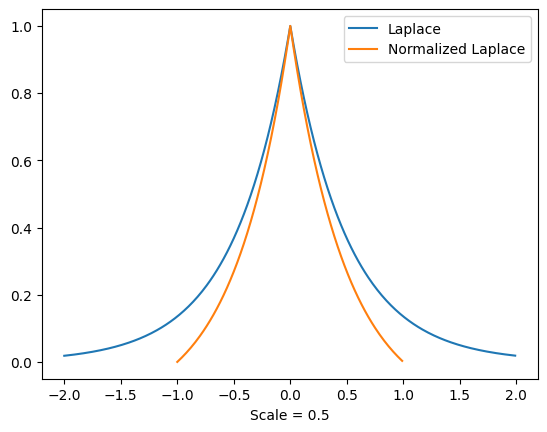

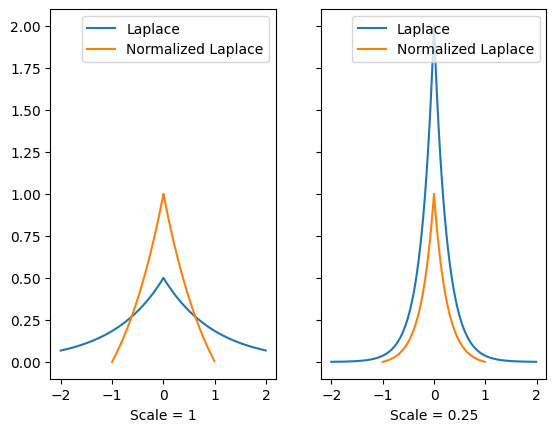

In [4]:
# Graph Laplace Distribution
import numpy as np
import matplotlib.pyplot as plt

def laplace_at(x: float | np.ndarray, loc=0, scale=0.5):
    return np.exp(-abs(x-loc)/scale)/(2.*scale)

def graph_laplace_and_normalized(scale, loc=0, min=1):
    x = np.arange(-2, 2, 0.01)
    normalized_x = np.arange(-1, 1, 0.01)

    laplace_dist = lambda y: laplace_at(y, scale=scale, loc=loc)

    pdf = laplace_dist(x)
    normalized_pdf = (laplace_dist(normalized_x) - laplace_dist(min)) / (laplace_dist(loc) - laplace_dist(min))

    return ((x, pdf),(normalized_x, normalized_pdf))


((x, pdf), (x2, modified_pdf)) = graph_laplace_and_normalized(0.5)
fig, ax = plt.subplots()
line1, = ax.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax.legend()
ax.set_xlabel('Scale = 0.5')

((x, pdf), (x2, modified_pdf)) = graph_laplace_and_normalized(1)
((x3, pdf2), (x4, modified_pdf2)) = graph_laplace_and_normalized(0.25)

fig2, (ax1, ax2) = plt.subplots(1,2, sharey=True)
line1, = ax1.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax1.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax1.legend()
ax1.set_xlabel('Scale = 1')
line3, = ax2.plot(x3, pdf2)
line3.set_label('Laplace')
line4, = ax2.plot(x4, modified_pdf2)
line4.set_label('Normalized Laplace')
ax2.legend()
ax2.set_xlabel('Scale = 0.25')


In [5]:
%load_ext autoreload
%autoreload now
import pruning_funcs
import copy

tests = np.arange(0.001, 0.01, 0.001)

num_trials = 5

print()
print('Avg. accuracy at scale values for Normalized Laplace Distribution')

print()
print('Unpruned Model')
print(f'Accuracy: {'%.2f' % evaluate_model(model, testloader, suppress_output=True)}%\tPercent Zero: {'%.2f' % pruning_funcs.percent_zero_weights(model)}%')

print()
print("Pruned Models (Normalized Laplace)")
for prune_scale in tests:
    accuracy = 0.
    percent_zeros = 0.
    for i in range(num_trials):
        pruned_model = copy.deepcopy(model)
        pruning_funcs.normalized_laplace_prune(pruned_model, device, scale=prune_scale)
        accuracy += evaluate_model(pruned_model, testloader, suppress_output=True)
        percent_zeros += pruning_funcs.percent_zero_weights(pruned_model)
    accuracy /= num_trials
    percent_zeros /= num_trials
    print(f'Scale: {'%.3f' % prune_scale}\tAvg. Accuracy: {'%.2f' % accuracy}%\tAvg. Percent Zero: {'%.2f' % percent_zeros}%')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Avg. accuracy at scale values for Normalized Laplace Distribution

Unpruned Model
Accuracy: 80.71%	Percent Zero: 0.00%

Pruned Models (Normalized Laplace)
Scale: 0.001	Avg. Accuracy: 80.75%	Avg. Percent Zero: 3.31%
Scale: 0.002	Avg. Accuracy: 80.70%	Avg. Percent Zero: 6.59%
Scale: 0.003	Avg. Accuracy: 80.65%	Avg. Percent Zero: 9.79%
Scale: 0.004	Avg. Accuracy: 80.39%	Avg. Percent Zero: 12.89%
Scale: 0.005	Avg. Accuracy: 80.24%	Avg. Percent Zero: 15.89%
Scale: 0.006	Avg. Accuracy: 79.76%	Avg. Percent Zero: 18.75%
Scale: 0.007	Avg. Accuracy: 79.76%	Avg. Percent Zero: 21.49%
Scale: 0.008	Avg. Accuracy: 78.59%	Avg. Percent Zero: 24.08%
Scale: 0.009	Avg. Accuracy: 77.97%	Avg. Percent Zero: 26.55%


In [6]:
percents = np.arange(1,6,1)

print("Pruned Models (Standard Percent Pruning)")
for percent in percents:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.percent_prune(pruned_model, device, percent=percent)
    accuracy = evaluate_model(pruned_model, testloader, suppress_output=True)
    percent_zero = pruning_funcs.percent_zero_weights(pruned_model)

    print(f'Theoretic percent pruned: {percent}%\tActual percent pruned: {'%.2f' % percent_zero}%\tAccuracy: {'%.2f' % accuracy}%')


Pruned Models (Standard Percent Pruning)
Theoretic percent pruned: 1%	Actual percent pruned: 1.00%	Accuracy: 79.45%
Theoretic percent pruned: 2%	Actual percent pruned: 2.00%	Accuracy: 75.72%
Theoretic percent pruned: 3%	Actual percent pruned: 3.00%	Accuracy: 73.58%
Theoretic percent pruned: 4%	Actual percent pruned: 4.00%	Accuracy: 68.46%
Theoretic percent pruned: 5%	Actual percent pruned: 5.00%	Accuracy: 63.06%
